# Text Classification - Sentiment Analysis - NLP

Buatlah model Sentiment Analysis menggunakan traditional Machine Learning algorithm dengan feature berupa bag of words. Gunakan data pada repository: https://github.com/IndoNLP/indonlu/tree/master/dataset/smsa_doc-sentiment-prosa 

Lakukan eksperimen untuk variasi feature extraction yang telah diajarkan di kelas yaitu bag of words dengan traditional ML algorithm (minimal 3 algoritme). Tetapkan preprocessing apa yang digunakan.

## Library Used

In [63]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
import re

In [6]:
data_train_preprocess =  pd.read_csv('data/train_preprocess.tsv', sep='\t', header=None, names=['text', 'label'])
data_test_preprocess = pd.read_csv('data/test_preprocess.tsv', sep='\t', header=None, names=['text', 'label'])
data_test_preprocess_masked_label = pd.read_csv('data/test_preprocess_masked_label.tsv', sep='\t', header=None, names=['text', 'label'])
data_valid_preprocess = pd.read_csv('data/valid_preprocess.tsv', sep='\t', header=None, names=['text', 'label'])

X_train = data_train_preprocess['text']
y_train = data_train_preprocess['label']

X_test = data_test_preprocess['text']
y_test = data_test_preprocess['label']

X_test_masked_label = data_test_preprocess_masked_label['text']
y_test_masked_label = data_test_preprocess_masked_label['label']

X_valid = data_valid_preprocess['text']
y_valid = data_valid_preprocess['label']

## Data Analysis

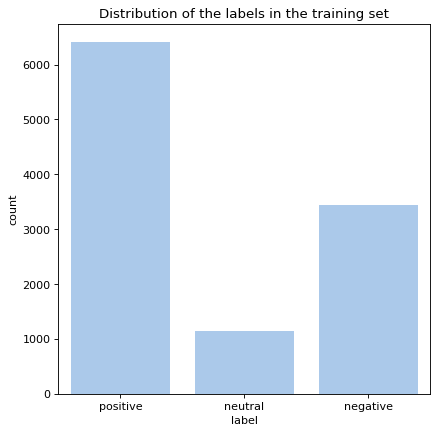

In [7]:
# data analysis

# Graph of the distribution of the labels
def plot_distribution(y, title):
    sns.set_palette('pastel')
    plt.figure(figsize=(6, 6), dpi=80)
    sns.countplot(x=y)
    plt.title(title)
    plt.show()
    
plot_distribution(y_train, 'Distribution of the labels in the training set')

In [8]:
# solve the problem of class imbalance with RandomOverSampler

ros = RandomOverSampler(random_state=0)
X_train_oversample, y_train_oversample = ros.fit_resample(pd.DataFrame(X_train), pd.DataFrame(y_train))

# Graph of the distribution of the labels after solving the problem of class imbalance
y_train_oversample = y_train_oversample["label"]
X_train_oversample = X_train_oversample["text"]

In [9]:
# solve the problem of class imbalance with undersampling

rus = RandomUnderSampler(random_state=0)
X_train_undersample, y_train_undersample = rus.fit_resample(pd.DataFrame(X_train), pd.DataFrame(y_train))

# Graph of the distribution of the labels after solving the problem of class imbalance
y_train_undersample = y_train_undersample["label"]
X_train_undersample = X_train_undersample["text"]

## Preprocessing

In [10]:
def preprocess_text(text: str) -> str:
    text = text.lower()
    text = text.replace('\n', ' ').replace('\r', ' ').replace('\t', ' ')
    # entity masking
    # url masking
    text = re.sub(r'http\S+', 'url', text)
    # email masking
    text = re.sub(r'\S+@\S+', 'email', text)
    # phone number masking 9 digits or more, with or without space, with - or without
    text = re.sub(r'(\d{9,}|\d{3,}[-\s]\d{3,}[-\s]\d{3,})', 'phone_number', text)
    return text

X_train_oversample = X_train_oversample.apply(lambda x: preprocess_text(x))
X_train_undersample = X_train_undersample.apply(lambda x: preprocess_text(x))
X_train_normal = X_train.apply(lambda x: preprocess_text(x))

X_test = X_test.apply(lambda x: preprocess_text(x))
X_test_masked_label = X_test_masked_label.apply(lambda x: preprocess_text(x))
X_valid = X_valid.apply(lambda x: preprocess_text(x))

In [11]:
# Initialize vectorizer globally so the same one can be used for both train and test

# Function to fit on training data and transform to bag of words
def bag_of_words(texts_train: pd.Series, texts_test: pd.Series) -> np.ndarray:
    vectorizer = CountVectorizer(max_features=1000)
    X_train = vectorizer.fit_transform(texts_train).toarray()
    X_test = vectorizer.transform(texts_test).toarray()
    return X_train, X_test

In [15]:
# Encoding the labels
y_train_oversample = LabelEncoder().fit_transform(y_train_oversample)
y_train_undersample = LabelEncoder().fit_transform(y_train_undersample)
y_train_normal = LabelEncoder().fit_transform(y_train)

y_test = LabelEncoder().fit_transform(y_test)
y_test_masked_label = LabelEncoder().fit_transform(y_test_masked_label)
y_valid = LabelEncoder().fit_transform(y_valid)

# display the label encoding and its corresponding class
label_mapping = dict(zip(LabelEncoder().fit(y_train).transform(LabelEncoder().fit(y_train).classes_), LabelEncoder().fit(y_train).classes_))
print(label_mapping)

{0: 'negative', 1: 'neutral', 2: 'positive'}


## Model

### Logistic Regression 

In [12]:
# Model training
# Logistic Regression
def logistic_regression(X_train, y_train, X_test, y_test):
    if type(X_train) == pd.Series:
        X_train, X_test = bag_of_words(X_train, X_test)
    # Model training
    logistic_regression = LogisticRegression(max_iter=1000)
    logistic_regression.fit(X_train, y_train)
    
    # Model evaluation
    y_pred = logistic_regression.predict(X_test)
    print(classification_report(y_test, y_pred))
    
    return logistic_regression

In [454]:
# Logistic Regression
print('Logistic Regression')
print('normal')
logistic_regression(X_train_normal, y_train_normal, X_test, y_test)
print('undersample')
logistic_regression(X_train_undersample, y_train_undersample, X_test, y_test)
print('oversample')
logrec = logistic_regression(X_train_oversample, y_train_oversample, X_test, y_test)

Logistic Regression
normal
              precision    recall  f1-score   support

           0       0.73      0.91      0.81       204
           1       0.81      0.44      0.57        88
           2       0.82      0.78      0.80       208

    accuracy                           0.77       500
   macro avg       0.79      0.71      0.73       500
weighted avg       0.78      0.77      0.76       500

undersample
              precision    recall  f1-score   support

           0       0.65      0.91      0.76       204
           1       0.55      0.74      0.63        88
           2       0.89      0.41      0.56       208

    accuracy                           0.67       500
   macro avg       0.70      0.69      0.65       500
weighted avg       0.73      0.67      0.65       500

oversample
              precision    recall  f1-score   support

           0       0.73      0.92      0.81       204
           1       0.65      0.58      0.61        88
           2       0.87  

In [19]:
text = ['aku buruk sekali', 'saya sangat senang', 'sekolah adalah tempat belajar']
text = [preprocess_text(x) for x in text]
text = pd.Series(text)
vectorizer = CountVectorizer(max_features=1000)
y_predict = np.array([0, 2, 1])

In [20]:
logistic_regression(X_train_oversample, y_train_oversample, text, y_predict)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       1.00      1.00      1.00         1
           2       1.00      1.00      1.00         1

    accuracy                           1.00         3
   macro avg       1.00      1.00      1.00         3
weighted avg       1.00      1.00      1.00         3



LogisticRegression(max_iter=1000)

In [427]:
logistic_regression(X_train_normal, y_train_normal, X_valid, y_valid)
logistic_regression(X_train_oversample, y_train_oversample, X_valid, y_valid)

              precision    recall  f1-score   support

           0       0.78      0.84      0.81       394
           1       0.69      0.70      0.70       131
           2       0.92      0.88      0.90       735

    accuracy                           0.85      1260
   macro avg       0.80      0.80      0.80      1260
weighted avg       0.85      0.85      0.85      1260

              precision    recall  f1-score   support

           0       0.77      0.85      0.81       394
           1       0.61      0.81      0.70       131
           2       0.94      0.84      0.89       735

    accuracy                           0.84      1260
   macro avg       0.78      0.83      0.80      1260
weighted avg       0.85      0.84      0.84      1260



LogisticRegression(max_iter=1000)

In [24]:
# X train oversample after bag of words
X_train_normal_bow, X_test_bow = bag_of_words(X_train_normal, X_test)
ros = RandomOverSampler(random_state=0)
X_train_oversample_new, y_train_oversample_new = ros.fit_resample(X_train_normal_bow, y_train_normal)

Hasil dari logistic regression dengan data oversampling setelah dilakukan feature extraction dengan bag of words adalah sebagai berikut:

In [28]:
logistic_regression(X_train_oversample_new, y_train_oversample_new, X_test_bow, y_test)

              precision    recall  f1-score   support

           0       0.72      0.93      0.81       204
           1       0.69      0.60      0.64        88
           2       0.89      0.68      0.77       208

    accuracy                           0.77       500
   macro avg       0.77      0.74      0.74       500
weighted avg       0.79      0.77      0.77       500



LogisticRegression(max_iter=1000)

Dari hasil di atas, didapatkan bahwa nilai F1 score tertinggi dengan akurasi yang cukup tinggi juga pada algoritma Logistic Regression dengan oversampling setelah dilakukan feature extraction dengan bag of words.

In [29]:
_, X_test_bow = bag_of_words(X_train_normal, X_valid)
logistic_regression(X_train_oversample_new, y_train_oversample_new, X_test_bow, y_valid)

              precision    recall  f1-score   support

           0       0.76      0.82      0.79       394
           1       0.58      0.82      0.68       131
           2       0.94      0.83      0.88       735

    accuracy                           0.83      1260
   macro avg       0.76      0.82      0.78      1260
weighted avg       0.85      0.83      0.83      1260



LogisticRegression(max_iter=1000)

### Naive Bayes

In [100]:
# Naive Bayes
def naive_bayes(X_train, y_train, X_test, y_test):
    if type(X_train) == pd.Series:
        print('bag of words')
        X_train, X_test = bag_of_words(X_train, X_test)
        
    # Model training
    naive_bayes = MultinomialNB(alpha=0.8)
    naive_bayes.fit(X_train, y_train)
    
    # Model evaluation
    y_pred = naive_bayes.predict(X_test)
    print(classification_report(y_test, y_pred))
    
    return naive_bayes

In [102]:
_, X_test_bow = bag_of_words(X_train_normal, X_test)
naive_bayes(X_train_oversample_new, y_train_oversample_new, X_test_bow, y_test)

naive_bayes(X_train_normal, y_train_normal, X_valid, y_valid)

naive_bayes(X_train_oversample, y_train_oversample, X_test, y_test)

              precision    recall  f1-score   support

           0       0.59      0.98      0.74       204
           1       0.55      0.50      0.52        88
           2       0.82      0.32      0.46       208

    accuracy                           0.62       500
   macro avg       0.65      0.60      0.57       500
weighted avg       0.68      0.62      0.58       500

bag of words
              precision    recall  f1-score   support

           0       0.76      0.81      0.78       394
           1       0.70      0.66      0.68       131
           2       0.90      0.88      0.89       735

    accuracy                           0.83      1260
   macro avg       0.79      0.78      0.78      1260
weighted avg       0.84      0.83      0.83      1260

bag of words
              precision    recall  f1-score   support

           0       0.58      0.98      0.73       204
           1       0.50      0.47      0.48        88
           2       0.83      0.30      0.44      

MultinomialNB(alpha=0.8)

### k-Nearst Neighbors

In [76]:
#  k-Nearest Neighbors
def knn(X_train, y_train, X_test, y_test):
    if type(X_train) == pd.Series:
        X_train, X_test = bag_of_words(X_train, X_test)
        
    # Model training
    knn = KNeighborsClassifier(n_neighbors=1)
    knn.fit(X_train, y_train)
    
    # Model evaluation
    y_pred = knn.predict(X_test)
    print(classification_report(y_test, y_pred))
    
    return knn

In [77]:
knn(X_train_oversample_new, y_train_oversample_new, X_test_bow, y_test)

              precision    recall  f1-score   support

           0       0.57      0.58      0.57       204
           1       0.38      0.68      0.49        88
           2       0.56      0.37      0.44       208

    accuracy                           0.51       500
   macro avg       0.50      0.54      0.50       500
weighted avg       0.53      0.51      0.50       500



KNeighborsClassifier(n_neighbors=1)

### CatBoost

In [95]:
# catboost
def catboost(X_train, y_train, X_test, y_test):
    if type(X_train) == pd.Series:
        X_train, X_test = bag_of_words(X_train, X_test)
        
    # Model training
    catboost = CatBoostClassifier(iterations=3000, learning_rate=0.1, depth=6, loss_function='MultiClass')
    catboost.fit(X_train, y_train)
    
    # Model evaluation
    y_pred = catboost.predict(X_test)
    print(classification_report(y_test, y_pred))
    
    return catboost

In [96]:
catboost(X_train_oversample_new, y_train_oversample_new, X_test_bow, y_test)

0:	learn: 1.0372029	total: 26.7ms	remaining: 1m 20s
1:	learn: 0.9906290	total: 55.2ms	remaining: 1m 22s
2:	learn: 0.9502462	total: 84.7ms	remaining: 1m 24s
3:	learn: 0.9182230	total: 107ms	remaining: 1m 20s
4:	learn: 0.8913665	total: 133ms	remaining: 1m 19s
5:	learn: 0.8658675	total: 150ms	remaining: 1m 14s
6:	learn: 0.8439259	total: 173ms	remaining: 1m 13s
7:	learn: 0.8248557	total: 195ms	remaining: 1m 13s
8:	learn: 0.8091005	total: 219ms	remaining: 1m 12s
9:	learn: 0.7934504	total: 242ms	remaining: 1m 12s
10:	learn: 0.7795280	total: 270ms	remaining: 1m 13s
11:	learn: 0.7677076	total: 292ms	remaining: 1m 12s
12:	learn: 0.7560897	total: 315ms	remaining: 1m 12s
13:	learn: 0.7459522	total: 335ms	remaining: 1m 11s
14:	learn: 0.7362517	total: 359ms	remaining: 1m 11s
15:	learn: 0.7283866	total: 380ms	remaining: 1m 10s
16:	learn: 0.7210919	total: 405ms	remaining: 1m 11s
17:	learn: 0.7130611	total: 425ms	remaining: 1m 10s
18:	learn: 0.7055372	total: 444ms	remaining: 1m 9s
19:	learn: 0.6996869

### Support Vector Machine (SVM)

In [456]:

# Model training
# Support Vector Machine
def support_vector_machine(X_train, y_train, X_test, y_test):
    if type(X_train) == pd.Series:
        X_train, X_test = bag_of_words(X_train, X_test)
    # Model training
    svm = SVC(kernel='linear')
    svm.fit(X_train, y_train)
    
    # Model evaluation
    y_pred = svm.predict(X_test)
    print(classification_report(y_test, y_pred))
    
    return svm

In [457]:
# Support Vector Machine
print('Support Vector Machine')
print('normal')
support_vector_machine(X_train_normal, y_train_normal, X_test, y_test)
print('undersample')
support_vector_machine(X_train_undersample, y_train_undersample, X_test, y_test)
print('oversample')
svm = support_vector_machine(X_train_oversample, y_train_oversample, X_test, y_test)

Support Vector Machine
normal
              precision    recall  f1-score   support

           0       0.69      0.92      0.79       204
           1       0.74      0.44      0.55        88
           2       0.85      0.71      0.77       208

    accuracy                           0.75       500
   macro avg       0.76      0.69      0.71       500
weighted avg       0.76      0.75      0.74       500

undersample
              precision    recall  f1-score   support

           0       0.62      0.90      0.74       204
           1       0.54      0.66      0.59        88
           2       0.88      0.42      0.57       208

    accuracy                           0.66       500
   macro avg       0.68      0.66      0.63       500
weighted avg       0.71      0.66      0.64       500

oversample
              precision    recall  f1-score   support

           0       0.66      0.92      0.77       204
           1       0.67      0.49      0.57        88
           2       0.8

In [458]:
print('oversample after bag of words')
support_vector_machine(X_train_oversample_new, y_train_oversample_new, X_test_bow, y_test)

oversample after bag of words
              precision    recall  f1-score   support

           0       0.67      0.92      0.77       204
           1       0.69      0.52      0.59        88
           2       0.89      0.65      0.75       208

    accuracy                           0.74       500
   macro avg       0.75      0.70      0.71       500
weighted avg       0.76      0.74      0.73       500



SVC(kernel='linear')

### Random Forest

In [459]:
# Model training
# Random Forest
def random_forest(X_train, y_train, X_test, y_test):
    if type(X_train) == pd.Series:
        X_train, X_test = bag_of_words(X_train, X_test)
    # Model training
    random_forest = RandomForestClassifier(n_estimators=100)
    random_forest.fit(X_train, y_train)
    
    # Model evaluation
    y_pred = random_forest.predict(X_test)
    print(classification_report(y_test, y_pred))
    
    return random_forest

In [365]:
# Random Forest
print('Random Forest')
print('normal')
random_forest(X_train_normal, y_train_normal, X_test, y_test)
print('undersample')
random_forest(X_train_undersample, y_train_undersample, X_test, y_test)
print('oversample')
rf = random_forest(X_train_oversample, y_train_oversample, X_test, y_test)

Random Forest
normal
              precision    recall  f1-score   support

           0       0.59      0.91      0.72       204
           1       0.65      0.27      0.38        88
           2       0.81      0.58      0.68       208

    accuracy                           0.66       500
   macro avg       0.68      0.59      0.59       500
weighted avg       0.69      0.66      0.64       500

undersample
              precision    recall  f1-score   support

           0       0.56      0.94      0.70       204
           1       0.53      0.57      0.55        88
           2       0.84      0.25      0.39       208

    accuracy                           0.59       500
   macro avg       0.64      0.59      0.55       500
weighted avg       0.67      0.59      0.54       500

oversample
              precision    recall  f1-score   support

           0       0.58      0.93      0.71       204
           1       0.62      0.30      0.40        88
           2       0.81      0.

In [460]:
print('oversample after bag of words')
random_forest(X_train_oversample_new, y_train_oversample_new, X_test_bow, y_test)

oversample after bag of words
              precision    recall  f1-score   support

           0       0.57      0.93      0.71       204
           1       0.64      0.36      0.46        88
           2       0.82      0.48      0.60       208

    accuracy                           0.64       500
   macro avg       0.68      0.59      0.59       500
weighted avg       0.69      0.64      0.62       500



RandomForestClassifier()

### other algorithm

In [376]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV

# Grid search to find the best parameters
text_clf = Pipeline([
    ('vect', CountVectorizer()), # Bag of words
    ('tfidf', TfidfTransformer()), # TF-IDF
    ('clf', SGDClassifier()), # Stochastic Gradient Descent
])

parameters = {
    'vect__ngram_range': [(1, 1), (1, 2), (2, 2)],
    'tfidf__use_idf': (True, False),
    'clf__alpha': (1e-2, 1e-3),
    'clf__penalty': ('l2', 'elasticnet'),
}

gs_clf = GridSearchCV(text_clf, parameters, cv=5, n_jobs=-1)

In [377]:
gs_clf = gs_clf.fit(X_train_normal, y_train_normal)
print(gs_clf.best_score_)

0.8314545454545454


In [378]:
gs_clf_under = gs_clf.fit(X_train_undersample, y_train_undersample)
print(gs_clf_under.best_score_)

0.840589664832754


In [462]:
gs_clf_over = gs_clf.fit(X_train_oversample, y_train_oversample)
print(gs_clf_over.best_score_)

0.9112651827258219


In [380]:
# result model
# print the best parameters
print(gs_clf_over.best_params_)

y_pred = gs_clf_over.predict(X_valid)
print(classification_report(y_valid, y_pred))

{'clf__alpha': 0.001, 'clf__penalty': 'l2', 'tfidf__use_idf': True, 'vect__ngram_range': (2, 2)}
              precision    recall  f1-score   support

           0       0.76      0.76      0.76       394
           1       0.74      0.57      0.65       131
           2       0.87      0.91      0.89       735

    accuracy                           0.83      1260
   macro avg       0.79      0.75      0.77      1260
weighted avg       0.82      0.83      0.82      1260



In [381]:
y_pred = gs_clf_over.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.65      0.87      0.74       204
           1       0.53      0.42      0.47        88
           2       0.75      0.56      0.64       208

    accuracy                           0.66       500
   macro avg       0.64      0.62      0.62       500
weighted avg       0.67      0.66      0.65       500

